We will start by importing all the packages we need. We will add more to this section as we go. 

In [1]:
import os
import pandas as pd
# Import necessary libraries
from tqdm import tqdm
import pandas as pd
import numpy as np
from scapy.all import rdpcap, TCP, IP
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scapy.all import rdpcap, TCP, IP
import numpy as np
import warnings

warnings.filterwarnings("ignore")


pcap_dir = 'output_dir/'


#NUM_FILES should be, at maximum, 20884 because that is the number of data file in output_dir.
#However, this is such a large dataset that it crashes my kernel. Therefore we will set it to a smaller number
#And only use a subset of the data.
#I have only tested up to 1000 because it any larger seems to risk crashing my kernel.
NUM_FILES = 1000


Creating a df with the labels and the location of the features

In [2]:
pcap_files = [f for f in os.listdir(pcap_dir) if f.endswith('.pcap')]

sample_ids = []
labels = []

for file in pcap_files:
    parts = file.split('_')
    sample_id = parts[0]
    label = parts[1].replace('.pcap', '')
    sample_ids.append(sample_id)
    labels.append(label)

data = pd.DataFrame({
    'sampleID': sample_ids,
    'label': labels,
    'filepath': [os.path.join(pcap_dir, f) for f in pcap_files]
})

#Displaying to get a feeling for the output
print(data.head())


               sampleID    label                                      filepath
0  11128135789608740605  youtube  output_dir/11128135789608740605_youtube.pcap
1   1326062620521889375  youtube   output_dir/1326062620521889375_youtube.pcap
2   9606350208298304688   amazon    output_dir/9606350208298304688_amazon.pcap
3    394452418702735955  netflix    output_dir/394452418702735955_netflix.pcap
4  16122494638576240387  netflix  output_dir/16122494638576240387_netflix.pcap


Extracting features

In [ ]:
def extract_features(pcap_file):

    try:
        packets = rdpcap(pcap_file)
    except Exception as e:
        print(f"Error reading {pcap_file}: {e}")
        return None

    syn_packets = []
    for pkt in packets:
        if IP in pkt and TCP in pkt:
            tcp_layer = pkt[TCP]
            if tcp_layer.flags & 0x02:
                syn_packets.append(pkt)
                if len(syn_packets) == 10:
                    break

    if len(syn_packets) != 10:
        print(f"Warning: {pcap_file} contains {len(syn_packets)} SYN packets instead of 10.")

    features = {}

    for i, pkt in enumerate(syn_packets, 1):
        features[f'syn_{i}_pkt_len'] = len(pkt)
        features[f'syn_{i}_src_port'] = pkt[TCP].sport
        features[f'syn_{i}_dst_port'] = pkt[TCP].dport
        features[f'syn_{i}_time'] = pkt.time

    #inter-arrival times packets
    times = [pkt.time for pkt in syn_packets]
    inter_arrival_times = np.diff(times)
    for i, inter_time in enumerate(inter_arrival_times, 1):
        features[f'syn_{i}_inter_arrival'] = inter_time

    return features


Here we are creating the the ultimate dataframe of features and labels which we will use to train our model

In [4]:
def process_pcap_files(data, num_files=1000):

    data_subset = data.head(num_files).reset_index(drop=True)

    feature_list = []

    for index, row in tqdm(data_subset.iterrows(), total=data_subset.shape[0], desc="Extracting features"):
        pcap_file = row['filepath']
        features = extract_features(pcap_file)
        if features is not None:
            feature_list.append(features)
        else:
            default_features = {}
            for i in range(1, 11):
                default_features[f'syn_{i}_pkt_len'] = 0
                default_features[f'syn_{i}_src_port'] = 0
                default_features[f'syn_{i}_dst_port'] = 0
                default_features[f'syn_{i}_time'] = 0.0
            for i in range(1, 10):
                default_features[f'syn_{i}_inter_arrival'] = 0.0
            feature_list.append(default_features)

    features_df = pd.DataFrame(feature_list)
    data_features = pd.concat([data_subset.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)

    return data_features

data_features = process_pcap_files(data, num_files=NUM_FILES)
print(data_features.head())



Extracting features: 100%|██████████| 1000/1000 [01:26<00:00, 11.59it/s]


               sampleID    label  \
0  11128135789608740605  youtube   
1   1326062620521889375  youtube   
2   9606350208298304688   amazon   
3    394452418702735955  netflix   
4  16122494638576240387  netflix   

                                       filepath  syn_1_pkt_len  \
0  output_dir/11128135789608740605_youtube.pcap             78   
1   output_dir/1326062620521889375_youtube.pcap             74   
2    output_dir/9606350208298304688_amazon.pcap             74   
3    output_dir/394452418702735955_netflix.pcap             74   
4  output_dir/16122494638576240387_netflix.pcap             66   

   syn_1_src_port  syn_1_dst_port         syn_1_time  syn_2_pkt_len  \
0           55450             443  1516845938.986545             78   
1           44216             443  1518267130.401981             74   
2           45730             443  1524779210.880480             74   
3           38058             443  1514613372.017846             74   
4           58495             4

Creating a mapping of labels to numbers for easier use

In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

data_features['label_encoded'] = label_encoder.fit_transform(data_features['label'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
for label, encoded in label_mapping.items():
    print(f"{label}: {encoded}")

# Checking mapping
print(data_features[['label', 'label_encoded']].head())


Label Encoding Mapping:
amazon: 0
netflix: 1
twitch: 2
youtube: 3
     label  label_encoded
0  youtube              3
1  youtube              3
2   amazon              0
3  netflix              1
4  netflix              1


We have to scale our features before training

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib

exclude_columns = ['sampleID', 'label', 'label_encoded', 'filepath']

feature_columns = [col for col in data_features.columns if col not in exclude_columns]

print("Feature Columns to be Scaled:")
print(feature_columns)

non_numeric_cols = data_features[feature_columns].select_dtypes(exclude=['number']).columns.tolist()
if non_numeric_cols:
    print("\nRemoving the following columns")
    print(non_numeric_cols)
    # Remove non-numeric columns from feature_columns
    feature_columns = [col for col in feature_columns if col not in non_numeric_cols]
    print("\nColumns scaled:")
    print(feature_columns)

scaler = StandardScaler()

data_features[feature_columns] = scaler.fit_transform(data_features[feature_columns])

print("\nScaled Feature Data:")
print(data_features[feature_columns].head())

joblib.dump(scaler, 'scaler.pkl')
print("\nScaler has been saved to 'scaler.pkl'.")


Feature Columns to be Scaled:
['syn_1_pkt_len', 'syn_1_src_port', 'syn_1_dst_port', 'syn_1_time', 'syn_2_pkt_len', 'syn_2_src_port', 'syn_2_dst_port', 'syn_2_time', 'syn_3_pkt_len', 'syn_3_src_port', 'syn_3_dst_port', 'syn_3_time', 'syn_4_pkt_len', 'syn_4_src_port', 'syn_4_dst_port', 'syn_4_time', 'syn_5_pkt_len', 'syn_5_src_port', 'syn_5_dst_port', 'syn_5_time', 'syn_6_pkt_len', 'syn_6_src_port', 'syn_6_dst_port', 'syn_6_time', 'syn_7_pkt_len', 'syn_7_src_port', 'syn_7_dst_port', 'syn_7_time', 'syn_8_pkt_len', 'syn_8_src_port', 'syn_8_dst_port', 'syn_8_time', 'syn_9_pkt_len', 'syn_9_src_port', 'syn_9_dst_port', 'syn_9_time', 'syn_10_pkt_len', 'syn_10_src_port', 'syn_10_dst_port', 'syn_10_time', 'syn_1_inter_arrival', 'syn_2_inter_arrival', 'syn_3_inter_arrival', 'syn_4_inter_arrival', 'syn_5_inter_arrival', 'syn_6_inter_arrival', 'syn_7_inter_arrival', 'syn_8_inter_arrival', 'syn_9_inter_arrival']

Removing the following columns
['syn_1_time', 'syn_2_time', 'syn_3_time', 'syn_4_time',

Splitting the data into training and testing sets

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

exclude_columns = ['sampleID', 'label', 'label_encoded', 'filepath']

feature_columns = [col for col in data_features.columns if col not in exclude_columns]

print("Feature Columns to be Used for Training:")
print(feature_columns)

X = data_features[feature_columns]
y = data_features['label_encoded']

TEST_SIZE = 0.2  # 20% for testing
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"\nTotal samples: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

def display_class_distribution(y, title):
    distribution = y.value_counts(normalize=True) * 100
    print(f"\n{title} Class Distribution:")
    print(distribution.round(2))

#Relative distributions
display_class_distribution(y, "Original Dataset")
display_class_distribution(y_train, "Training Set")
display_class_distribution(y_test, "Testing Set")


Feature Columns to be Used for Training:
['syn_1_pkt_len', 'syn_1_src_port', 'syn_1_dst_port', 'syn_1_time', 'syn_2_pkt_len', 'syn_2_src_port', 'syn_2_dst_port', 'syn_2_time', 'syn_3_pkt_len', 'syn_3_src_port', 'syn_3_dst_port', 'syn_3_time', 'syn_4_pkt_len', 'syn_4_src_port', 'syn_4_dst_port', 'syn_4_time', 'syn_5_pkt_len', 'syn_5_src_port', 'syn_5_dst_port', 'syn_5_time', 'syn_6_pkt_len', 'syn_6_src_port', 'syn_6_dst_port', 'syn_6_time', 'syn_7_pkt_len', 'syn_7_src_port', 'syn_7_dst_port', 'syn_7_time', 'syn_8_pkt_len', 'syn_8_src_port', 'syn_8_dst_port', 'syn_8_time', 'syn_9_pkt_len', 'syn_9_src_port', 'syn_9_dst_port', 'syn_9_time', 'syn_10_pkt_len', 'syn_10_src_port', 'syn_10_dst_port', 'syn_10_time', 'syn_1_inter_arrival', 'syn_2_inter_arrival', 'syn_3_inter_arrival', 'syn_4_inter_arrival', 'syn_5_inter_arrival', 'syn_6_inter_arrival', 'syn_7_inter_arrival', 'syn_8_inter_arrival', 'syn_9_inter_arrival']

Total samples: 1000
Training samples: 800
Testing samples: 200

Original Dat

Now we will train our random forest classifier. We are chosing random forest because of its versatility and robustness. 


Balanced Accuracy on Test Set: 0.7513

Classification Report:
              precision    recall  f1-score   support

      amazon       0.87      0.72      0.79        18
     netflix       0.74      0.63      0.68        59
      twitch       0.81      0.68      0.74        31
     youtube       0.83      0.98      0.90        92

    accuracy                           0.81       200
   macro avg       0.81      0.75      0.77       200
weighted avg       0.80      0.81      0.80       200



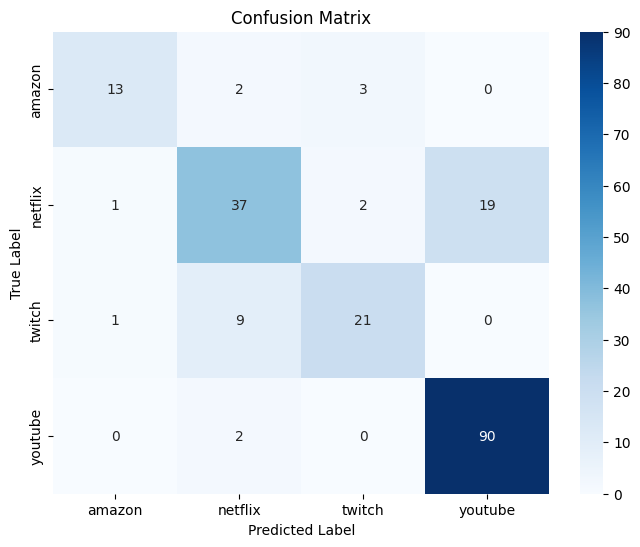

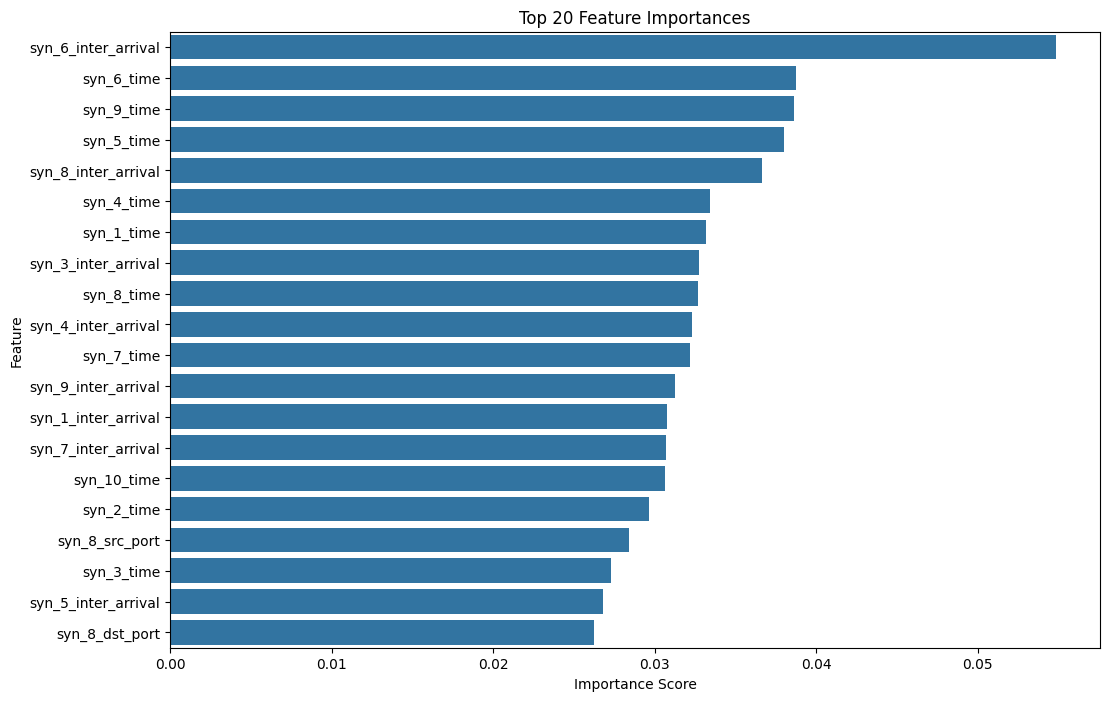

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

rf_classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy on Test Set: {balanced_acc:.4f}")

class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("\nClassification Report:")
print(class_report)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature importances
importances = rf_classifier.feature_importances_
feature_names = X_train.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances[:20], y=feature_importances.index[:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


Now we will hypertune our parameters

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters Found:
bootstrap: True
class_weight: balanced
max_depth: 10
min_samples_leaf: 4
min_samples_split: 6
n_estimators: 215

Cross-Validation Balanced Accuracy: 0.7303

Balanced Accuracy with the best model: 0.7669
              precision    recall  f1-score   support

      amazon       0.70      0.78      0.74        18
     netflix       0.75      0.56      0.64        59
      twitch       0.81      0.81      0.81        31
     youtube       0.81      0.92      0.86        92

    accuracy                           0.79       200
   macro avg       0.77      0.77      0.76       200
weighted avg       0.78      0.79      0.78       200



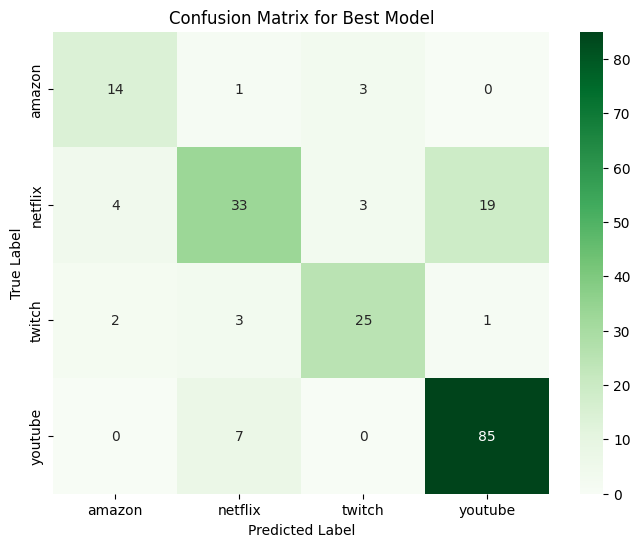

In [ ]:

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np
from scipy.stats import randint, uniform
from tqdm import tqdm

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False],
    'class_weight': ['balanced', None]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='balanced_accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)


random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print("\nBest Parameters Found:")
for param, value in best_params.items():
    print(f"{param}: {value}")

print(f"\nCross-Validation Balanced Accuracy: {best_score:.4f}")


best_rf = random_search.best_estimator_

y_pred_best = best_rf.predict(X_test)

balanced_acc_best = balanced_accuracy_score(y_test, y_pred_best)
print(f"\nBalanced Accuracy with the best model: {balanced_acc_best:.4f}")

class_report_best = classification_report(y_test, y_pred_best, target_names=label_encoder.classes_)
print(class_report_best)

conf_matrix_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Best Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()